In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
survey_df = pd.read_csv('../data/online-v1-prolific-sample.csv')
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q_work_urban,Q_work_urban_3_TEXT,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,PROLIFIC_PID,STUDY_ID,treatment
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Do you work in an urban area? - Selected Choice,Do you work in an urban area? - Not sure / Oth...,How old are you?,What is your gender?,What was your total household income before ta...,Choose one or more races that you consider you...,Any extra comments? (optional),PROLIFIC_PID,STUDY_ID,treatment
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID63""}","{""ImportId"":""QID63_3_TEXT""}","{""ImportId"":""QID30""}","{""ImportId"":""QID57""}","{""ImportId"":""QID25""}","{""ImportId"":""QID24""}","{""ImportId"":""QID58_TEXT""}","{""ImportId"":""PROLIFIC_PID""}","{""ImportId"":""STUDY_ID""}","{""ImportId"":""treatment""}"
2,2022-06-28 09:30:49,2022-06-28 09:32:52,0,*******,100,123,1,2022-06-28 09:32:52,R_125SdSXI0xLI29S,*******,...,1,NaN,4,1,6,1,NaN,5ae11f9709eae20001132c22,62bb1ba7f2c710e36fd2c1be,labeled
3,2022-06-28 09:30:31,2022-06-28 09:34:22,0,*******,100,231,1,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,*******,...,2,NaN,7,1,5,1,I do not lean toward either party. I am a libe...,5dd311bde25acf3254f36c9c,62bb1ba7f2c710e36fd2c1be,unlabeled
4,2022-06-28 09:31:35,2022-06-28 09:35:34,0,*******,100,239,1,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,*******,...,2,NaN,5,2,2,1,"None, but thank you!",5ba3e40d2d28760001a377bb,62bb1ba7f2c710e36fd2c1bf,labeled


In [3]:
print(list(survey_df.columns))

['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'ProlificID ', 'Q_attn_1', 'Q_attn_2', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_attn_check', 'Q_current_hunger', 'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_attn_midway', 'Q_politics', 'Q_US_state', 'Q_live_urban', 'Q_work_urban', 'Q_work_urban_3_TEXT', 'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 'Q_comments', 'PR

## Data preprocessing


Transform into tables:


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choices table

```
ResponseId, labeled (1/0), QID, menu, comparison type (1-5), choice (1/0) 
```

In [4]:
choice_Q_prefix = 'Q_sandwich'
choice_Qs = [q for q in survey_df.columns if q.startswith(choice_Q_prefix)]
print(choice_Qs)

['Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled']


In [5]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 
    'PROLIFIC_PID', # embedded variable set through URL params
    'Finished','Duration (in seconds)', 'RecordedDate',
    'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway', 
    'Q_current_hunger', 'Q_live_urban', 'Q_work_urban', 'Q_politics', 'Q_US_state',
    'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 
    'Q_good_for_env', 'Q_how_important_env',
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

### Respondent table

In [6]:
respondent_df = survey_df.drop([0,1])[respondent_columns]
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=495 total responses before data cleaning


,ResponseId,PROLIFIC_PID,Finished,Duration (in seconds),RecordedDate,Q_attn_1,Q_attn_2,Q_attn_check,Q_attn_midway,Q_current_hunger,...,Q_vegetarian_not_me,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
2,R_125SdSXI0xLI29S,5ae11f9709eae20001132c22,1,123,2022-06-28 09:32:52,21,5,"1,2",5,3,...,4,4,2,4,4,1,6,1,NaN,labeled
3,R_23V4Eyckqxl6Bmy,5dd311bde25acf3254f36c9c,1,231,2022-06-28 09:34:23,21,5,"1,2",5,2,...,3,3,2,4,7,1,5,1,I do not lean toward either party. I am a libe...,unlabeled
4,R_2c5wLF9HxTeZ30h,5ba3e40d2d28760001a377bb,1,239,2022-06-28 09:35:35,21,5,"1,2",5,2,...,4,4,1,5,5,2,2,1,"None, but thank you!",labeled


In [7]:
# only include completed surveys via Prolific
N_PROLIFIC_PID_na = len(respondent_df[respondent_df['PROLIFIC_PID'].isna()])
print('dropping %s non PROLIFIC responses' % N_PROLIFIC_PID_na)
respondent_df = respondent_df[respondent_df['PROLIFIC_PID'].notna()]
N_uncompleted = len(respondent_df[respondent_df['Finished'] != '1'])
respondent_df = respondent_df[respondent_df['Finished'] == '1']
print('dropping %s incomplete responses' % N_uncompleted)

dropping 1 non PROLIFIC responses
dropping 0 incomplete responses


In [8]:
def passed_attn_checks(row):
    if not ((row['Q_attn_1'] == 'twenty one') or (int(row['Q_attn_1']) == 21)):
        print(row['ResponseId'], 'failed Q_attn_1')
        return False
    if int(row['Q_attn_2']) != 5:
        print(row['ResponseId'], 'failed Q_attn_2')
        return False
    if row['Q_attn_check'] != '1,2':
        print(row['ResponseId'], 'failed Q_attn_check')
        return False
    if int(row['Q_attn_midway']) != 5:
        print(row['ResponseId'], 'failed Q_attn_midway')
        return False
    return True

In [9]:
respondent_df['passed_attn_checks'] = respondent_df.apply(passed_attn_checks, axis=1)
passed_attn_checks_ResponseId_list = list(respondent_df[respondent_df.passed_attn_checks == True].ResponseId)
print('%s/%s respondents passed all attention checks' % (len(passed_attn_checks_ResponseId_list), len(respondent_df)))
# passed_attn_checks_ResponseId_list

R_1Nagt8YYb9KXsgu failed Q_attn_check
R_25u12nxsbq17quY failed Q_attn_2
R_1ewLnYbEh64px5y failed Q_attn_2
R_3EbCFbWypJAH9eU failed Q_attn_2
R_31sGHSw29sejYZu failed Q_attn_check
R_XNtU8UZMHfqK8lX failed Q_attn_2
R_1Ov4PG2EqkoaNBI failed Q_attn_2
R_2sbRJWBoxeF0yHs failed Q_attn_2
R_3Hho2J2KAXLsDob failed Q_attn_2
R_3HUPi75tTdT9pnD failed Q_attn_2
R_1eLSotOLp5DjqJP failed Q_attn_2
R_1LLnNW2RfOKf93z failed Q_attn_midway
R_3fvnmHGH7Bmp938 failed Q_attn_2
R_33mAmfZaIBDBZiT failed Q_attn_2
R_3g8l72aZYNXtcZh failed Q_attn_check
R_1CjxgolIeuRdypP failed Q_attn_check
R_UDAbbOpDeLg8Jot failed Q_attn_check
R_1HqLpaBDw6P827V failed Q_attn_2
R_pR8DHCNXAHa8ZFv failed Q_attn_2
475/494 respondents passed all attention checks


Drop responses from participants who failed ANY attention check

In [10]:
print('dropping responses from participants who failed any attention check')
respondent_df = respondent_df[respondent_df['passed_attn_checks']]

dropping responses from participants who failed any attention check


### Codebook

In [11]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [12]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_current_hunger': {
        'Q': 'How would you rank your current hunger level on a scale from 1 - 4?',
        'choices': {
            '1':'1 (Not hungry at all)','2':'2','3':'3','4':'4 (Very hungry)'
        },
    },
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_priorities': {
        'Q': 'How do you prioritize the following when choosing what to order for yourself off a menu?',
        'choices': {'1':'health','2':'cost','3':'taste','4':'filling','5':'usual_choice'},
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_how_important_env': {
        'Q':'How important is environmental sustainability to you as an issue?',
        'choices': {
            '1':'Very much not important','2':'Not important',
            '3':'Neutral','4':'Somewhat important','5':'Very important'
        },
    },
    'Q_vegetarian_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegetarian dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_vegan_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegan dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_live_urban': {
        'Q':'Which best describes the area you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural'},
    },
    'Q_work_urban': {
        'Q': 'Do you work in an urban area?',
        'choices': {'1':'Yes', '2':'No','3':'Not sure / Other'},
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

In [13]:
for k in codebook.keys():
    if k == 'Q_priorities': continue
    assert(k in respondent_columns)

## Demographics


In which state do you currently reside?

Virginia            1
Michigan            1
Indiana             1
Oregon              1
Alabama             1
South Carolina      1
New York            1
Kansas              1
New Jersey          2
Pennsylvania        3
Texas               4
California          4
Vermont            19
New Hampshire      32
Rhode Island       34
Maine              45
Connecticut        97
Massachusetts     227
Name: Q_US_state, dtype: int64


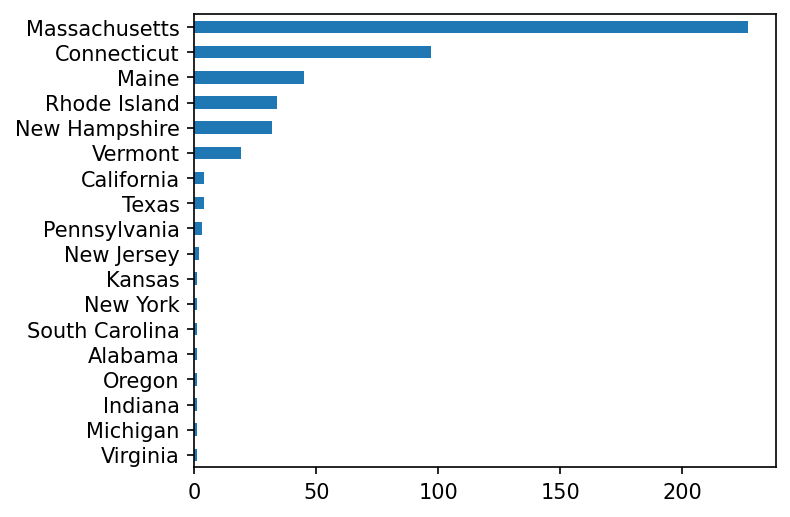

In [14]:
# Respondents by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(5,4), dpi=150)
respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']))

How old are you?


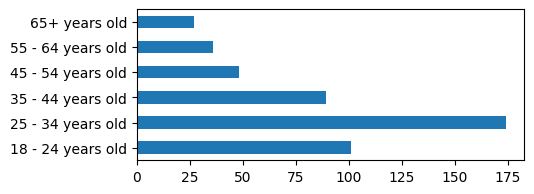

In [15]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(5,2), dpi=100)
_ = respondent_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']).plot.barh(ax=ax)
# print(respondent_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']))

What was your total household income before taxes during the past 12 months?



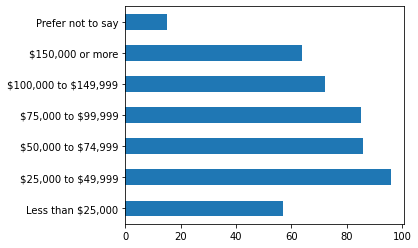

In [16]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(5,4))#, dpi=100)
_ = respondent_df['Q_demos_income'].value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)
# print(respondent_df['Q_demos_income'].value_counts().sort_index().rename(codebook['Q_demos_income']['choices']))

Female                  279
Male                    184
Other                    10
Prefer not to answer      2
Name: gender, dtype: int64

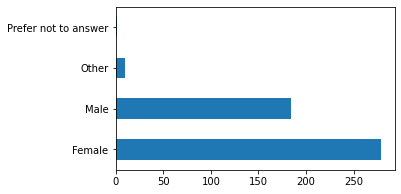

In [17]:
respondent_df['gender'] = respondent_df.Q_demos_gender.map(codebook['Q_demos_gender']['choices'])
fig,ax = plt.subplots(figsize=(5,3))
respondent_df['gender'].value_counts().plot.barh(ax=ax)
respondent_df['gender'].value_counts()

1,2,4      1
1,4,5      1
1,5        1
5          1
3          1
2,4        1
6          3
1,6        3
1,3        4
1,2        4
7          6
1,4        6
2         20
4         32
1        391
Name: Q_demos_race, dtype: int64


Native Hawaiian or Other Pacific Islander             1
American Indian/Native American or Alaska Native      1
Black or African American                            20
Other                                                30
Asian                                                32
White or Caucausian                                 391
Name: race, dtype: int64

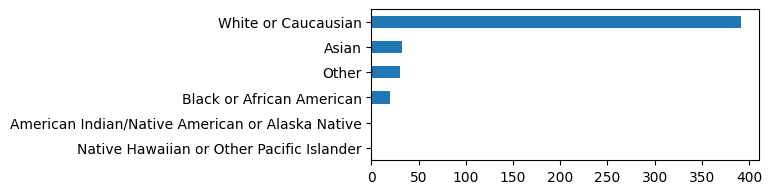

In [56]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
print(respondent_df['Q_demos_race'].value_counts().sort_values())
respondent_df['race'] = (respondent_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
fig,ax = plt.subplots(1,1,figsize=(5,2),dpi=100)
respondent_df['race'].value_counts().sort_values().plot.barh()
respondent_df['race'].value_counts().sort_values()

Strongly Democratic    134
Democratic             140
Lean Democratic        121
Lean Republican         58
Republican              16
Strongly Republican      6
Name: Q_politics, dtype: int64


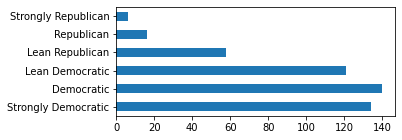

In [57]:
fig,ax = plt.subplots(figsize=(5,2))
respondent_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
print(respondent_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']))

Which best describes the area you live?


Suburban    292
Urban       106
Rural        77
Name: Q_live_urban, dtype: int64

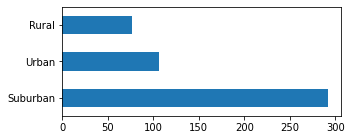

In [58]:
print(codebook['Q_live_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_live_urban'].value_counts().rename(
    codebook['Q_live_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_live_urban'].value_counts().rename(
    codebook['Q_live_urban']['choices'])

Do you work in an urban area?


No                  302
Yes                 157
Not sure / Other     16
Name: Q_work_urban, dtype: int64

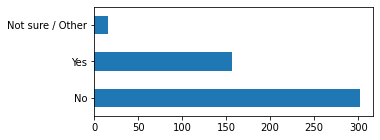

In [59]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices'])

Add a column indicating someone either lives or works in an urban area

In [60]:
def live_or_work_urban(row):
    return (row['Q_live_urban'] == '1') or (row['Q_work_urban'] == '1')

respondent_df['live_or_work_urban'] = respondent_df.apply(live_or_work_urban, axis=1)

Do you work in an urban area?


No                  302
Yes                 157
Not sure / Other     16
Name: Q_work_urban, dtype: int64

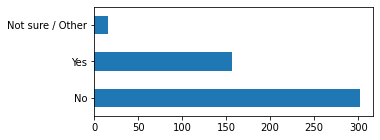

In [61]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices'])

Live or work urban

Live or work urban


False    288
True     187
Name: live_or_work_urban, dtype: int64

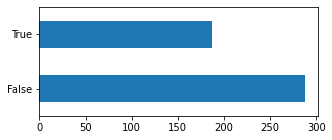

In [124]:
print('Live or work urban')
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['live_or_work_urban'].value_counts().plot.barh(ax=ax)
respondent_df['live_or_work_urban'].value_counts()

More correlations between covariates

In [78]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        vert=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        #capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False,
        rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


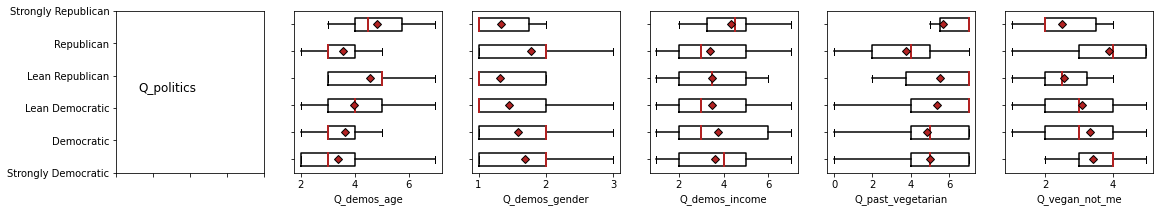

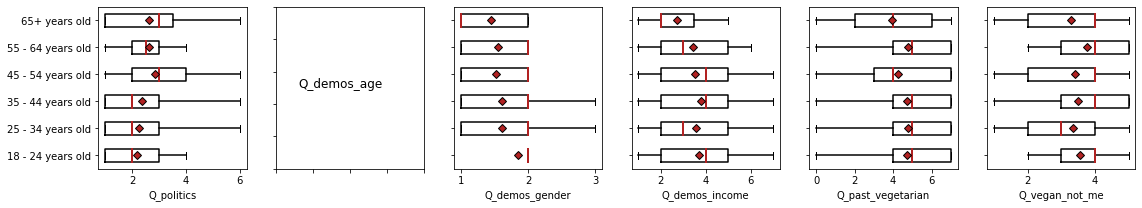

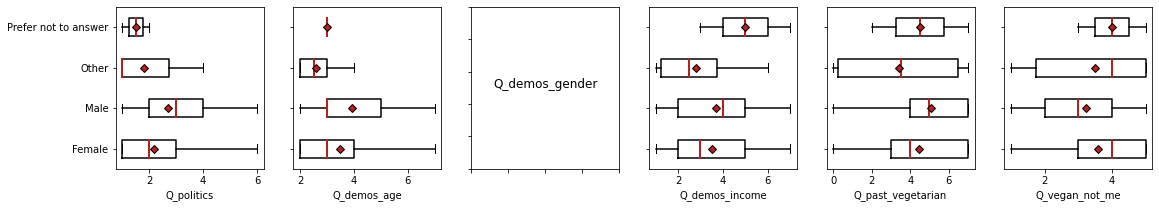

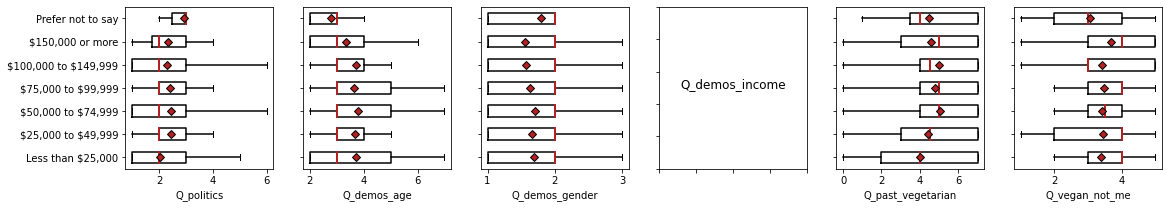

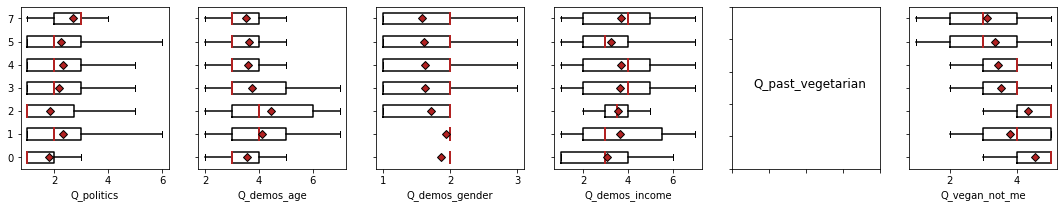

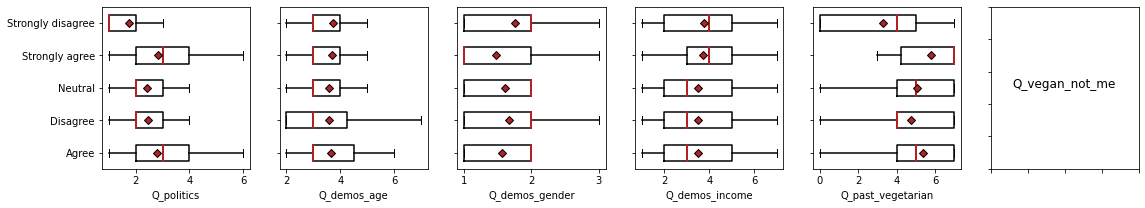

In [83]:
# Covariates correlations
cc_list = [
    'Q_politics', 
    'Q_demos_age', 
    'Q_demos_gender', 
    'Q_demos_income',
    'Q_past_vegetarian',
    'Q_vegan_not_me',
    
]
# make a df for analysis
df = respondent_df[cc_list].copy()


alt_map = ['Q_demos_income']
n_ccs = len(cc_list)


for i in range(n_ccs):
    fig, axes = plt.subplots(1,n_ccs, figsize=(3*n_ccs,3),
                             facecolor='w', edgecolor='k')
    for j in range(n_ccs):
        ax = axes[j]
        cc_i = cc_list[i]
        cc_j = cc_list[j]
        if i == j:
            if i == 0:
                ax.set_yticklabels(list(codebook[cc_i]['choices'].values()))
            else:
                ax.set_yticklabels([])
            ax.text(0.15, 0.5, cc_i, fontsize = 12)
            ax.set_xticklabels([])
            continue
        rdf = df[[cc_i, cc_j]].copy()
        if cc_i not in alt_map:
            rdf[cc_i] = rdf[cc_i].map(codebook[cc_i]['choices'])
        rdf[cc_j] = rdf[cc_j].astype(float)
        styled_boxplot(rdf, by=cc_i, column=cc_j, ax=ax)
        if j > 0:
            ax.set_yticklabels([])
        if (cc_i in alt_map) and (j==0):
            ax.set_yticklabels(codebook[cc_i]['choices'].values())
        ax.set_xlabel(cc_j)
        ax.set_title('')
        # ax.set_title('%s' % (cc_j))

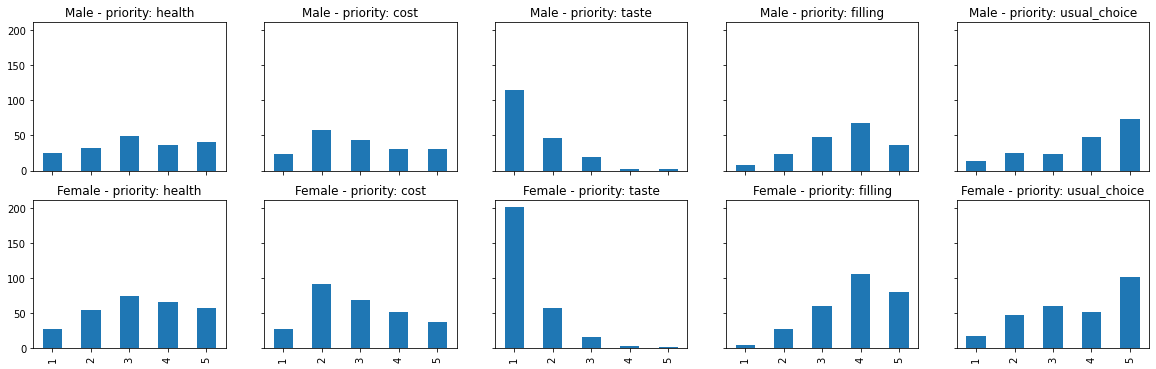

In [75]:
priorities_N = len(codebook['Q_priorities']['choices'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(codebook['Q_priorities']['choices'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)
    


None           392
Vegetarian      30
Other           17
Pescatarian     10
Keto             6
Gluten free      5
Vegan            5
Name: Q_special_diet, dtype: int64


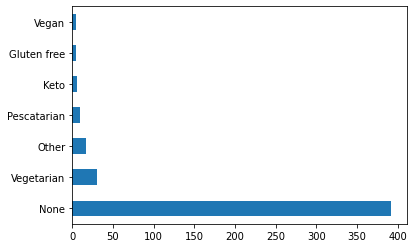

In [28]:
respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts().plot.barh()
print(respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts())

In [29]:
"""
Add in diet specific varaibles:
is_vegetarian
is_vegan
is_v : (is_vegetarian|is_vegan)
diet_other : said had a special diet that is not veg
diet_none : answered None for special diet
"""
respondent_df['is_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
respondent_df['is_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)
respondent_df['is_v'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if (('3' in d) or ('5' in d)) else 0)
respondent_df['diet_other'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: ('3' not in d) and ('5' not in d) and ('7' not in d))
respondent_df['diet_none'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: '7' in d)
respondent_df['diet_none'].sum()

393

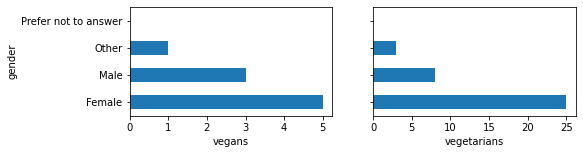

In [30]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,2),sharey=True)
respondent_df.groupby('gender')['is_vegan'].sum().plot.barh(ax=ax1)
_ = respondent_df.groupby('gender')['is_vegetarian'].sum().plot.barh(ax=ax2)
ax1.set_xlabel('vegans')
_ = ax2.set_xlabel('vegetarians')

How important is environmental sustainability to you as an issue?
1     16
2     20
3     47
4    205
5    187
Name: Q_how_important_env, dtype: int64
Very much not important     16
Not important               20
Neutral                     47
Somewhat important         205
Very important             187
Name: Q_how_important_env, dtype: int64


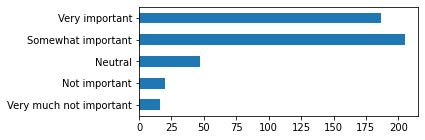

In [84]:
print(codebook['Q_how_important_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']))

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       128
Agree                219
Neutral              116
Disagree               8
Strongly disagree      4
Name: Q_good_for_env, dtype: int64


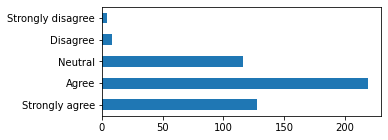

In [88]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']))

### Menu choices table

```
ResponseId, labeled (0/1), QID, menu, choice_type (1-5), choice (1,2) 
```

In [89]:
# Wide data
choices_wide_df = (survey_df[['ResponseId'] + choice_Qs].drop([0,1]))
# drop data from respondents who failed attention checks
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(passed_attn_checks_ResponseId_list))
]
choices_wide_df.head(3)

,ResponseId,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,Q_sandwich_5,Q_sandwich_1_labeled,Q_sandwich_2_labeled,Q_sandwich_3_labeled,Q_sandwich_4_labeled,Q_sandwich_5_labeled
2,R_125SdSXI0xLI29S,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1
3,R_23V4Eyckqxl6Bmy,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
4,R_2c5wLF9HxTeZ30h,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [93]:
# Transform the wide data to long data.
choices_df = pd.melt(choices_wide_df, 
                     id_vars=['ResponseId'], value_vars=choice_Qs, 
                     var_name='QID', value_name='choice')
choices_df.head()

,ResponseId,QID,choice
0,R_125SdSXI0xLI29S,Q_sandwich_1,NaN
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0
2,R_2c5wLF9HxTeZ30h,Q_sandwich_1,NaN
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0
4,R_2BrfiuSgy1SNVbL,Q_sandwich_1,NaN


In [101]:
# Add Q data
# ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0)
# code choice, choice_type, labeled as numeric
choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: int(QID.split('_')[2]))
choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
# only keep responses for answered questions
print('dropping unanswered Qs; respondents answer %s = %s/%s of total Qs' % (
    len(choices_df.dropna())/len(choices_df), len(choices_df.dropna()), len(choices_df)
))
choices_df = choices_df.dropna()
choices_df['choice'] = choices_df['choice'].astype(int)
choices_df.head()

dropping unanswered Qs; respondents answer 1.0 = 2375/2375 of total Qs


,ResponseId,QID,choice,choice_type,labeled,age,income,race,is_v,is_vegetarian,is_vegan
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0,7,5,White or Caucausian,0,0,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0,4,2,White or Caucausian,0,0,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0,5,5,White or Caucausian,0,0,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0,5,4,White or Caucausian,0,0,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0,2,4,Asian,0,0,0


## Modeling


## Main effects by comparison type

In [102]:
choices_type_names_dict = {
    1:'1=(labeled) vegetarian vs 0=meat',
    2:'1=(labeled) vegan vs 0=meat',
    3:'1=(labeled) vegetarian vs 0=vegetarian',
    4:'1=(labeled) vegan vs 0=vegan',
    5:'1=(labeled) vegan vs 0=vegetarian',
}

Add in demographic covariates to choices df

In [103]:
# code gender as male=1; otherwise=0
choices_df['male'] = choices_df['ResponseId'].apply(lambda r: 1 if response_genders[r]=='1' else 0)
# choices_df

In [104]:
choices_df['age'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_age'])
choices_df['income'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_income'])
choices_df['race'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['race'])

In [105]:
# Put in the diet related variables
for d in ['is_v', 'is_vegetarian', 'is_vegan']:
    choices_df[d] = choices_df.ResponseId.map(respondent_df.set_index('ResponseId')[d])

In [106]:
response_genders = respondent_df.set_index('ResponseId')['Q_demos_gender']
# response_genders

Test for for non-veg

In [107]:
def get_non_veg_choices_df(df):
    return df[(choices_df.is_v==0)]

By choice type, considering gender

In [108]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.610358
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      430
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.01924
Time:                        00:11:22   Log-Likelihood:                -264.28
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                  0.005600
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3981  

In [109]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.610223
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      429
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.01946
Time:                        00:11:26   Log-Likelihood:                -264.23
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                   0.01485
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

With demographic covariates

In [111]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + age + income", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.598911
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      419
Method:                           MLE   Df Model:                           13
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.03764
Time:                        00:13:18   Log-Likelihood:                -259.33
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                   0.08837
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.418

In [112]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male + age + income", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.598785
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                           14
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.03784
Time:                        00:14:42   Log-Likelihood:                -259.27
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                    0.1183
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

## Tests with moderator variables

Test with is_vegetarian and is_vegan as moderators

In [43]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ male + is_vegetarian + labeled + labeled:is_vegetarian", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

         Current function value: 0.580858
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  475
Model:                          Logit   Df Residuals:                      470
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Jul 2022   Pseudo R-squ.:                  0.1204
Time:                        23:24:23   Log-Likelihood:                -275.91
converged:                      False   LL-Null:                       -313.66
Covariance Type:            nonrobust   LLR p-value:                 1.555e-15
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3948     

                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  475
Model:                          Logit   Df Residuals:                      470
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Jul 2022   Pseudo R-squ.:                0.006798
Time:                        23:24:23   Log-Likelihood:                -321.72
converged:                       True   LL-Null:                       -323.92
Covariance Type:            nonrobust   LLR p-value:                    0.3541
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2971      0.156     -1.899      0.058      -0.604       0.009
male                      0.1963      0.192      1.023      0.306      -0.180       0.572
is_veget

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test with priority:health as a moderator, using whether health rated in top 2 priorities

In [114]:
Q_priorities_col_map = {'Q_priorities_%s'%k:'Q_priorities_%s'%v for k,v in codebook['Q_priorities']['choices'].items()}
# Q_priorities_col_map

In [115]:
# whether health in top 1-2 priorities
choices_df['priority_health'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId').rename(
    columns=Q_priorities_col_map
)['Q_priorities_health'].apply(lambda h: 1 if h in ['1','2'] else 0))
# choices_df['priority_health']

In [118]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit(
        "choice ~ labeled + male + priority_health + labeled:priority_health", 
        data=c_df
    ).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.606267
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      428
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.02582
Time:                        08:33:56   Log-Likelihood:                -262.51
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                  0.007578
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

With political leaning as moderator (non-veg only)

Note responses are skewed towards democratic learning participants

In [119]:
choices_df['politics'] = \
    choices_df['ResponseId'].map(respondent_df.set_index('ResponseId')['Q_politics'].astype(float))
choices_df['politics'].describe()

count    2375.000000
mean        2.368421
std         1.181262
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: politics, dtype: float64

In [120]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + politics + labeled:politics", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.602110
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      428
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.03249
Time:                        08:34:49   Log-Likelihood:                -260.71
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                  0.001537
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept  

With urban as moderator (menu: sandwich; non-veg only)

In [128]:
choices_df['live_or_work_urban'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['live_or_work_urban'].apply(lambda u: 1 if u else 0))
# choices_df['live_or_work_urban']

In [129]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + live_or_work_urban + labeled:live_or_work_urban", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.608211
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  433
Model:                          Logit   Df Residuals:                      428
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.02269
Time:                        08:50:13   Log-Likelihood:                -263.36
converged:                       True   LL-Null:                       -269.47
Covariance Type:            nonrobust   LLR p-value:                   0.01573
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

### Multilevel modeling


We also use a hierarchical logistic regression model, where choices from all choice types are included in the model, and the participant-level effect is controlled for.

In [130]:
from pymer4.models import Lmer

In [133]:
m = Lmer("choice ~ labeled + (labeled|ResponseId)", data=choices_df, family="binomial")
m.fit()

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2375	 Groups: {'ResponseId': 475.0}

Log-likelihood: -1559.719 	 AIC: 3129.437

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.253  0.503
ResponseId      labeled  0.665  0.816

                    IV1      IV2   Corr
ResponseId  (Intercept)  labeled -0.191

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.427,-0.564,-0.290,0.070,0.652,0.569,0.748,0.395,0.363,0.428,-6.108,0.000,***
labeled,-0.194,-0.414,0.026,0.112,0.824,0.661,1.027,0.452,0.398,0.507,-1.725,0.084,.


In [136]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + (labeled|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Formula: choice~labeled+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2165	 Groups: {'ResponseId': 433.0}

Log-likelihood: -1396.499 	 AIC: 2802.997

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.203  0.451
ResponseId      labeled  0.574  0.758

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled -0.28

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.518,-0.659,-0.378,0.072,0.596,0.518,0.686,0.373,0.341,0.407,-7.224,0.000,***
labeled,-0.254,-0.479,-0.029,0.115,0.776,0.619,0.971,0.437,0.383,0.493,-2.213,0.027,*


In [138]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + male + (labeled|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

Formula: choice~labeled+male+(labeled|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2165	 Groups: {'ResponseId': 433.0}

Log-likelihood: -1395.841 	 AIC: 2803.682

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.196  0.442
ResponseId      labeled  0.551  0.742

                    IV1      IV2  Corr
ResponseId  (Intercept)  labeled -0.24

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.465,-0.631,-0.299,0.085,0.628,0.532,0.741,0.386,0.347,0.426,-5.499,0.000,***
labeled,-0.258,-0.483,-0.033,0.115,0.773,0.617,0.968,0.436,0.382,0.492,-2.247,0.025,*
male,-0.128,-0.347,0.091,0.112,0.880,0.706,1.095,0.468,0.414,0.523,-1.148,0.251,
